<a href="https://colab.research.google.com/github/jchen0000/widsdatathon2025/blob/main/python/CNN_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

# Neural Networks

This page includes neural network models:
- NN
- CNN 2D
- GCN

## Data Loading
Data processing notebook: [python/00_data_formating_and_imputation.ipynb](https://github.com/jchen0000/widsdatathon2025/blob/main/python/00_data_formating_and_imputation.ipynb)

Datasets available:
1. `df_train_mri` and `df_test_mri`: original train and test MRI flatten fc matrix
2. `df_train_meta_imputed` and `df_test_meta_imputed`: imputed train and test meta data (quant and cat combined)
3. `connectome_matrices` and `connectome_matrices_test`: reshaped 2d fc matrix (correlation matrix) for train and test
4. `df_train_y`: train response data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

## suppose you've created a folder named "widsdatathon2025"
%cd /content/drive/MyDrive/widsdatathon2025/
%ls

Mounted at /content/drive
/content/drive/MyDrive/widsdatathon2025
'Data Dictionary.xlsx'   SAMPLE_SUBMISSION.xlsx   TEST/                    TRAIN/
 gnn/                    submission/              test_imputed_test.xlsx   Work/


#### Load from Jiaqi's file

In [3]:
## load data
df_train_X = pd.read_csv('./Work/jiaqi_imputed/imputed_train_jiaqi.csv')
df_train_X = df_train_X.values

df_test_X = pd.read_csv('./Work/jiaqi_imputed/imputed_test_jiaqi.csv')
df_test_X = df_test_X.values

df_train_y = pd.read_excel("./TRAIN/TRAINING_SOLUTIONS.xlsx")
df_train_y.set_index('participant_id', inplace=True)
print(df_train_y.shape)

(1213, 2)


In [4]:
## get column and index
df_train_meta = pd.read_excel("./TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
df_train_meta.set_index('participant_id', inplace=True)
print(df_train_meta.shape)

df_test_meta = pd.read_excel("./TEST/TEST_CATEGORICAL.xlsx")
df_test_meta.set_index('participant_id', inplace=True)
print(df_test_meta.shape)

dtm = pd.read_csv("./TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
dtm.set_index('participant_id', inplace=True)
print(dtm.shape)

train_idx = df_train_meta.index.values
test_idx = df_test_meta.index.values
meta_cols = df_test_meta.columns.values
mri_cols = dtm.columns.values

(1213, 9)
(304, 9)
(304, 19900)


In [6]:
# Standardize features.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train_X_scaled = scaler.fit_transform(df_train_X)
df_test_X_scaled = scaler.transform(df_test_X)

In [7]:
### split into mri and meta data
df_train_mri = df_train_X_scaled[:, 27:]
df_train_meta_imputed = df_train_X_scaled[:, :27]
df_train_mri.shape

df_test_mri = df_test_X_scaled[:, 27:]
df_test_meta_imputed = df_test_X_scaled[:, :27]
df_test_mri.shape

df_train_mri = pd.DataFrame(df_train_mri, columns=mri_cols, index=df_train_meta.index)
df_test_mri = pd.DataFrame(df_test_mri, columns=mri_cols, index=df_test_meta.index)

#### Load from docs folloing Jiaqi's process

In [ ]:
# with np.load('./Work/scaled_data_jiaqi.npz') as data:
#   X_train_scaled = data['X_train_scaled']
#   X_test_scaled = data['X_test_scaled']

# df_train_y = pd.read_excel("./TRAIN/TRAINING_SOLUTIONS.xlsx")
# df_train_y.set_index('participant_id', inplace=True)
# print(df_train_y.shape)

(1213, 2)


In [ ]:
import pickle

with open('./Work/scaled_data_jiaqi.pkl', 'rb') as f:
  loaded_data = pickle.load(f)

X_train_scaled = loaded_data['X_train_scaled']
X_test_scaled = loaded_data['X_test_scaled']
# X_test_scaled = loaded_data['X_test_scaled']

print(X_train_scaled.shape)
X_test_scaled.shape

(1213, 19927)


(304, 19927)

In [ ]:
df_train_X = X_train_scaled
df_test_X = X_test_scaled

df_train_y = pd.read_excel("./TRAIN/TRAINING_SOLUTIONS.xlsx")
df_train_y.set_index('participant_id', inplace=True)
print(df_train_y.shape)

(1213, 2)


In [ ]:
df_train_mri = X_train_scaled.iloc[:, :19900]
df_train_meta_imputed = X_train_scaled.iloc[:, 19900:]
df_test_mri = X_test_scaled.iloc[:, :19900]
df_test_meta_imputed = X_test_scaled.iloc[:, 19900:]
print(df_test_mri.shape)
print(df_test_meta_imputed.shape)


(304, 19900)
(304, 27)


#### Reshape Matrix

In [8]:
## reconstruct connecticome matrix

import re

def extract_numbers(input_string):
  match = re.match(r"(\d+)throw_(\d+)thcolumn", input_string)
  if match:
    n = int(match.group(1))
    m = int(match.group(2))
    return n, m
  return None, None

def create_connectome_matrix(row):
  """Creates a connectome matrix from a row of the dataframe.

  Args:
    row: A pandas Series representing a row of df_train_mri.

  Returns:
    A NumPy array representing the connectome matrix.
  """
  # print(row)

  matrix = np.zeros((200, 200))
  for col_name, value in row.items():
    if isinstance(col_name, str):
      try:
        # print(col_name)
        nth_row, mth_col = extract_numbers(col_name)
        # print(nth_row, mth_col)
        if nth_row is not None and nth_row < 200 and mth_col < 200:
          matrix[nth_row, mth_col] = value
          matrix[mth_col, nth_row] = value
          # if nth_row < 5 and mth_col < 5:
          #   print(matrix[:5, :5])
      except ValueError:
        print('value error detected')
        pass  # Ignore columns that don't match the pattern
  np.fill_diagonal(matrix, 1)
  # print(matrix[:5,:5])
  return matrix


connectome_matrices = np.array([create_connectome_matrix(row) for _, row in df_train_mri.iterrows()])
connectome_matrices_test = np.array([create_connectome_matrix(row) for _, row in df_test_mri.iterrows()])
connectome_matrices.shape

# print(df_train_mri.iloc[0:5, :5])
# connectome_matrices[1,:5,:5]


(1213, 200, 200)

#### Load standardized files from pkl

In [ ]:
# prompt: load the pickle files

import pickle

# Load the training data
with open('./Work/data_train_scaled_yiru.pkl', 'rb') as f:
    train_data = pickle.load(f)
print("Training data loaded successfully.")

# Load the test data
with open('./Work/data_test_scaled_yiru.pkl', 'rb') as f:
    test_data = pickle.load(f)
print("Test data loaded successfully.")

# Access the loaded data
connectome_matrices = train_data['connectome_matrices']
df_train_mri = train_data['df_train_mri']
df_train_meta_imputed = train_data['df_train_meta_imputed']

connectome_matrices_test = test_data['connectome_matrices_test']
df_test_mri = test_data['df_test_mri']
df_test_meta_imputed = test_data['df_test_meta_imputed']


Training data loaded successfully.
Test data loaded successfully.


In [ ]:
df_train_y = pd.read_excel('./TRAIN/TRAINING_SOLUTIONS.xlsx')
df_train_y.set_index('participant_id', inplace=True)
print(df_train_y.shape)

(1213, 2)


#### Load individual files and large imputation file

In [ ]:
## train data
dir = './TRAIN/' #"./data/train/"
df_train_mri = pd.read_csv(dir+"TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")
df_train_mri.set_index('participant_id', inplace=True)
print(df_train_mri.shape)

connectome_matrices = np.load(dir+'connectome_matrices_train.npy')
print(connectome_matrices.shape)

df_train_meta_imputed = pd.read_excel(dir+"df_train_meta_KNN_imputed_yiru.xlsx")
df_train_meta_imputed.set_index('participant_id', inplace=True)
print(df_train_meta_imputed.shape)

df_train_X = pd.concat([df_train_mri, df_train_meta_imputed], axis=1)
print(df_train_X.shape)

df_train_y = pd.read_excel(dir+"TRAINING_SOLUTIONS.xlsx")
df_train_y.set_index('participant_id', inplace=True)
print(df_train_y.shape)

# Combine both columns for prediction
# (0,0): 0
# (0,1): 1
# (1,0): 2
# (1,1): 3
df_train_y_sparse = pd.DataFrame()
df_train_y_sparse['sparse_category'] = df_train_y['ADHD_Outcome'] *2 + df_train_y['Sex_F']

df_train_meta_imputed.head()

(1213, 19900)
(1213, 200, 200)
(1213, 27)
(1213, 19927)
(1213, 2)


,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
participant_id,,,,,,,,,,,,,,,,,,,,,
70z8Q2xdTXM3,2018,1,0.0,1,2,21,45,21,45,28.88,...,0,8,1,4,5,4,4,3,9,11.889002
WHWymJu6zNZi,2015,1,1.0,8,1,6,5,0,15,14.47,...,0,0,0,0,0,0,0,0,0,7.670088
4PAQp1M6EyAo,2019,1,0.0,0,2,18,35,9,20,26.68,...,8,26,4,17,8,9,9,5,8,7.743896
obEacy4Of68I,2017,1,0.0,0,2,21,40,21,40,55.67,...,0,7,2,4,1,4,3,1,10,12.116723
s7WzzDcmDOhF,2019,1,2.0,8,2,9,35,0,0,-26.68,...,3,14,3,6,3,3,8,5,6,8.903490


In [ ]:
# Test data
dir = './TEST/'
df_test_mri = pd.read_csv(dir+"TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
df_test_mri.set_index('participant_id', inplace=True)
print(df_test_mri.shape)

df_test_meta_imputed = pd.read_excel(dir+"df_test_meta_KNN_imputed_yiru.xlsx")
df_test_meta_imputed.set_index('participant_id', inplace=True)
print(df_test_meta_imputed.shape)

df_test_X = pd.concat([df_test_mri, df_test_meta_imputed], axis=1)
print(df_test_X.shape)

connectome_matrices_test = np.load(dir+'connectome_matrices_test.npy')
print(connectome_matrices_test.shape)

df_test_meta_imputed.head()

(304, 19900)
(304, 27)
(304, 19927)
(304, 200, 200)


,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
participant_id,,,,,,,,,,,,,,,,,,,,,
Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30,18.0,30,60.03,...,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45,18.6,30,86.71,...,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40,18.0,40,26.68,...,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45,21.0,45,93.38,...,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0,21.0,45,-93.38,...,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


In [ ]:
## double check on the test data meta data missing values

# check NA in original dataset
na_count_old = np.isnan(df_test_X).sum()
print(f"Number of NA values in df_train_X: {na_count_old.sum()}")
print(f"NA value per column (>0): \n{na_count_old[na_count_old > 0]}")

Number of NA values in df_train_X: 0
NA value per column (>0): 
Series([], dtype: int64)


#### Test on smaller imputation

In [ ]:
dir = './TRAIN/'
df_train_meta_quant = pd.read_excel(dir+"TRAIN_QUANTITATIVE_METADATA.xlsx")
df_train_meta_quant.set_index('participant_id', inplace=True)
print(df_train_meta_quant.shape)

df_train_meta_cat = pd.read_excel(dir+"TRAIN_CATEGORICAL_METADATA.xlsx")
df_train_meta_cat.set_index('participant_id', inplace=True)
print(df_train_meta_cat.shape)

# Test data
dir = './TEST/'
df_test_meta_quant = pd.read_excel(dir+"TEST_QUANTITATIVE_METADATA.xlsx")
df_test_meta_quant.set_index('participant_id', inplace=True)
print(df_test_meta_quant.shape)

df_test_meta_cat = pd.read_excel(dir+"TEST_CATEGORICAL.xlsx")
df_test_meta_cat.set_index('participant_id', inplace=True)
print(df_test_meta_cat.shape)




(1213, 18)
(1213, 9)
(304, 18)
(304, 9)


In [ ]:
# FAST: imputation only on meta data

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

df_train_meta = pd.concat([df_train_meta_cat, df_train_meta_quant], axis=1)
train_idx = df_train_X.index
df_test_meta = pd.concat([df_test_meta_cat, df_test_meta_quant], axis=1)
test_idx = df_test_X.index

df_meta = pd.concat([df_train_meta, df_test_meta], axis=0)
print(df_meta.shape)

df_meta[df_meta == "NA"] = np.nan

# Impute missing values with KNN imputation separately
imputer_metadata = KNNImputer(n_neighbors=5)  # Using KNN for imputation instead of mean
df_train_meta_imputed = imputer_metadata.fit_transform(df_train_meta)  # ((1213, 19927)
df_train_meta_imputed = pd.DataFrame(df_train_meta_imputed, columns=df_train_meta.columns, index=df_train_meta.index)
print(df_train_meta_imputed.shape)
df_train_meta_imputed.head(2)

df_test_meta_imputed = imputer_metadata.transform(df_test_meta)
# df_test_meta_imputed = imputer_metadata.fit_transform(df_test_meta)  # ((1213, 19927)
df_test_meta_imputed = pd.DataFrame(df_test_meta_imputed, columns=df_test_meta.columns, index=df_test_meta.index)
print(df_test_meta_imputed.shape)
df_test_meta_imputed.head(2)

# # Impute missing values with KNN imputation together
# imputer_metadata = KNNImputer(n_neighbors=5)  # Using KNN for imputation instead of mean
# df_meta_imputed = imputer_metadata.fit_transform(df_meta)  # ((1213, 19927)
# df_meta_imputed = pd.DataFrame(df_meta_imputed, columns=df_meta.columns, index=df_meta.index)
# print(df_meta_imputed.shape)
# df_meta_imputed.head(2)

# df_train_meta_imputed = df_meta_imputed.loc[train_idx, :]
# df_test_meta_imputed = df_meta_imputed.loc[test_idx, :]
# print(df_train_meta_imputed.shape, df_test_meta_imputed.shape)

(1517, 27)
(1213, 27)
(304, 27)


,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
participant_id,,,,,,,,,,,,,,,,,,,,,
Cfwaf5FX7jWK,2022.0,4.0,0.0,0.0,4.0,21.0,30.0,18.0,30.0,60.03,...,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
vhGrzmvA3Hjq,2023.0,4.0,0.0,0.0,4.0,21.0,45.0,19.2,30.0,86.71,...,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093


In [ ]:
# ## use large imputation for test set
# dir = './TEST/'
# df_test_meta_imputed = pd.read_excel(dir+"df_test_meta_KNN_imputed_yiru.xlsx")
# df_test_meta_imputed.set_index('participant_id', inplace=True)
# print(df_test_meta_imputed.shape)

#### Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize features.
scaler = StandardScaler()

df_train_X = pd.concat([df_train_mri, df_train_meta_imputed], axis=1)
df_test_X = pd.concat([df_test_mri, df_test_meta_imputed], axis=1)

df_train_X_scaled = scaler.fit_transform(df_train_X)
df_test_X_scaled = scaler.transform(df_test_X)

df_train_X = pd.DataFrame(df_train_X_scaled, columns=df_train_X.columns, index=df_train_X.index)
df_test_X = pd.DataFrame(df_test_X_scaled, columns=df_test_X.columns, index=df_test_X.index)

df_train_mri = df_train_X.loc[:, df_train_mri.columns]
df_train_meta_imputed = df_train_X.loc[:, df_train_meta_imputed.columns]
df_test_mri = df_test_X.loc[:, df_test_mri.columns]
df_test_meta_imputed = df_test_X.loc[:, df_test_meta_imputed.columns]
print(df_test_meta_imputed.shape)

# df_train_mri_scaled = scaler.fit_transform(df_train_mri)
# df_test_mri_scaled = scaler.transform(df_test_mri)

# df_train_meta_imputed_scaled = scaler.fit_transform(df_train_meta_imputed)
# df_test_meta_imputed_scaled = scaler.transform(df_test_meta_imputed)

# df_train_mri = pd.DataFrame(df_train_mri_scaled, columns=df_train_mri.columns, index=df_train_mri.index)
# df_test_mri = pd.DataFrame(df_test_mri_scaled, columns=df_test_mri.columns, index=df_test_mri.index)
# df_train_meta_imputed = pd.DataFrame(df_train_meta_imputed_scaled, columns=df_train_meta_imputed.columns, index=df_train_meta_imputed.index)
# df_test_meta_imputed = pd.DataFrame(df_test_meta_imputed_scaled, columns=df_test_meta_imputed.columns, index=df_test_meta_imputed.index)


(304, 27)


In [ ]:
## reconstruct connecticome matrix

import re

def extract_numbers(input_string):
  match = re.match(r"(\d+)throw_(\d+)thcolumn", input_string)
  if match:
    n = int(match.group(1))
    m = int(match.group(2))
    return n, m
  return None, None

def create_connectome_matrix(row):
  """Creates a connectome matrix from a row of the dataframe.

  Args:
    row: A pandas Series representing a row of df_train_mri.

  Returns:
    A NumPy array representing the connectome matrix.
  """
  # print(row)

  matrix = np.zeros((200, 200))
  for col_name, value in row.items():
    if isinstance(col_name, str):
      try:
        # print(col_name)
        nth_row, mth_col = extract_numbers(col_name)
        # print(nth_row, mth_col)
        if nth_row is not None and nth_row < 200 and mth_col < 200:
          matrix[nth_row, mth_col] = value
          matrix[mth_col, nth_row] = value
          # if nth_row < 5 and mth_col < 5:
          #   print(matrix[:5, :5])
      except ValueError:
        print('value error detected')
        pass  # Ignore columns that don't match the pattern
  np.fill_diagonal(matrix, 1)
  # print(matrix[:5,:5])
  return matrix


connectome_matrices = np.array([create_connectome_matrix(row) for _, row in df_train_mri.iterrows()])
connectome_matrices_test = np.array([create_connectome_matrix(row) for _, row in df_test_mri.iterrows()])
connectome_matrices.shape

# print(df_train_mri.iloc[0:5, :5])
# connectome_matrices[1,:5,:5]


(1213, 200, 200)

## Train-validation data splitting

In [24]:
# prompt: split df_train_X and df_train_y into train and validation set and convert df into arrays able to be input into keras model

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df_train_X_scaled, df_train_y, test_size=0.2, random_state=42)

# Convert DataFrames to NumPy arrays
# X_train = X_train.values
# X_val = X_val.values
y_train = y_train.values
y_val = y_val.values

print(y_val.shape)

(243, 2)


In [36]:
# prompt: split df_train_X and df_train_y into train and validation set and convert df into arrays able to be input into keras model

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_mri, X_val_mri, X_train_meta, X_val_meta, y_train, y_val = train_test_split(connectome_matrices, df_train_meta_imputed, df_train_y, test_size=0.2, random_state=42)

# Convert DataFrames to NumPy arrays
# X_train_meta = X_train_meta.values
# X_val_meta = X_val_meta.values
y_train = y_train.values
y_val = y_val.values

print(X_train_mri.shape)
print(X_train_meta.shape)
print(y_val.shape)

(970, 200, 200)
(970, 27)
(243, 2)


## Evaluation Metrics

In [10]:
# prompt: I have a y_true array with two columns and a y_pred array with two columns, I want to use both columns together to determine if it's correct or not. how to calculate the f1 score. customized the weight variable based on the y_true, setting each (1,1) pair in y_true as 2 in weight, all others are 1 in weight. use sklearn f1-score function if possible. construct the function to be used as the keras neural network training metrics. The input is two tensor array

import numpy as np
from sklearn.metrics import f1_score
import tensorflow as tf

def custom_f1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(tf.round(y_pred), tf.int32)

    if y_true.shape[-1] == 2:
      # Combine both columns for prediction
      # (0,0): 0
      # (0,1): 1
      # (1,0): 2
      # (1,1): 3
      y_true = y_true[:,0] * 2 + y_true[:,1]
      y_pred = y_pred[:,0] * 2 + y_pred[:,1]
    elif y_true.shape[-1] == 1:
      y_true = tf.squeeze(y_true)
      y_pred = tf.squeeze(y_pred)
    else:
      raise ValueError("y_true should have shape (None, 2) or (None, 1)")

    # Calculate weights
    weights = tf.where(tf.equal(y_true, 3), 2.0, 1.0)

    # Reshape for sklearn f1_score
    y_true_reshaped = tf.reshape(y_true, [-1]).numpy()
    y_pred_reshaped = tf.reshape(y_pred, [-1]).numpy()
    weights_reshaped = tf.reshape(weights, [-1]).numpy()
    print(y_true_reshaped.shape)
    print(y_pred_reshaped.shape)
    print(weights_reshaped.shape)

    f1 = f1_score(y_true_reshaped, y_pred_reshaped, average='weighted', sample_weight=weights_reshaped)
    return f1


In [11]:
## fake y_pred
y_pred = np.random.randint(0, 2, size=(y_train.shape[0], 2))
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)
print(y_train_tensor.shape)
print(y_pred_tensor.shape)

custom_f1(y_train, y_pred)

(970, 2)
(970, 2)
(970,)
(970,)
(970,)


0.2620694546508169

In [20]:
# --- Define the function to compute weighted F1 score ---
def compute_weighted_f1(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex):
    """
    Compute the final weighted F1 score for the competition.
    Female ADHD cases (where ADHD_Outcome==1 and Sex_F==1) are given 2x weight.
    The final score is the average of the weighted F1 for ADHD_Outcome and the F1 for Sex_F.
    """
    # Create sample weights for ADHD_Outcome: weight=2 for female ADHD cases, else 1.
    weights = np.ones_like(y_true_adhd, dtype=float)
    weights[(y_true_adhd == 1) & (y_true_sex == 1)] = 2.0

    # Calculate weighted F1 for ADHD_Outcome
    f1_adhd = f1_score(y_true_adhd, y_pred_adhd, sample_weight=weights)
    # Calculate standard F1 for Sex_F
    f1_sex = f1_score(y_true_sex, y_pred_sex)

    # Final leaderboard score: average of the two F1 scores
    final_f1 = (f1_adhd + f1_sex) / 2.0
    return final_f1, f1_adhd, f1_sex


In [21]:
# calculate_weighted_f1_score(y_train, y_pred)
y_true_sex = y_train[:,1]
y_pred_sex = y_pred[:,1]
y_true_adhd = y_train[:,0]
y_pred_adhd = y_pred[:,0]
compute_weighted_f1(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex)


(0.5123593523593524, 0.5835065835065835, 0.4412121212121212)

In [12]:
# prompt: help me write function to calculate weighted f1 score with 2 columns using sklearn, calculate the f1 score for each column with sample weights and get average score, each column have the same weight

def calculate_weighted_f1_score(y_true, y_pred):
  """Calculates the weighted F1 score for two columns with sample weights.

  Args:
    y_true: A NumPy array or pandas DataFrame of true labels with two columns.
    y_pred: A NumPy array or pandas DataFrame of predicted labels with two columns.

  Returns:
    The average weighted F1 score for both columns.
  """

  if isinstance(y_true, pd.DataFrame):
    y_true = y_true.values
  if isinstance(y_pred, pd.DataFrame):
    y_pred = y_pred.values

  # Weights
  weights = np.where((y_true[:, 0] == 1) & (y_true[:, 1] == 1), 2, 1)

  f1_scores = []
  for i in range(y_true.shape[1]):
    # Calculate F1 score for the current column with sample weights
    f1 = f1_score(y_true[:, i], y_pred[:, i], average='weighted', sample_weight=weights)
    f1_scores.append(f1)

  # Calculate the average F1 score for both columns (each with the same weight)
  average_f1 = np.mean(f1_scores)
  return average_f1


In [22]:
calculate_weighted_f1_score(y_train, y_pred)

np.float64(0.5209351078054119)

## Neural network

In [ ]:
# # prompt: I have a y_true array with two columns and a y_pred array with two columns, I want to use both columns together to determine if it's correct or not. how to calculate the f1 score. customized the weight variable based on the y_true, setting each (1,1) pair in y_true as 2 in weight, all others are 1 in weight. use sklearn f1-score function if possible. construct the function to be used in the keras neural network training metrics. The input is two tensor array

# import tensorflow as tf
# from sklearn.metrics import f1_score

# def custom_f1(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
#     print(y_true.shape)
#     print(y_pred.shape)

#     # Create weights based on y_true
#     weights = tf.where(tf.reduce_all(tf.equal(y_true, [[1.0, 1.0]]), axis=1), 2.0, 1.0)

#     # Calculate the F1 score using sklearn
#     f1 = tf.numpy_function(f1_score_with_weights,
#                            inp=[y_true, y_pred, weights],
#                            Tout=tf.float32)
#     return f1


# def f1_score_with_weights(y_true, y_pred, weights):
#     y_true = y_true.astype(int)
#     y_pred = y_pred.astype(int)
#     weights = weights.flatten()

#     # Combine both columns for prediction
#     # (0,0): 0
#     # (0,1): 1
#     # (1,0): 2
#     # (1,1): 3
#     combined_y_true = y_true[:,0] * 2 + y_true[:,1]
#     combined_y_pred = y_pred[:,0] * 2 + y_pred[:,1]

#     return f1_score(combined_y_true, combined_y_pred, average='weighted', sample_weight=weights)


In [ ]:
# ## fake y_pred
# y_pred = np.random.randint(0, 2, size=(y_train.shape[0], 2))
# y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
# y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)
# custom_f1(y_train_tensor, y_pred_tensor)

(970, 2)
(970, 2)


<tf.Tensor: shape=(), dtype=float32, numpy=0.26099467277526855>

In [25]:
# prompt: set up a neural network model with an input layer of 19927 cells, and output layer of 2 cells, add dropoff layer if needed, add activation functions. try use keras package to do that.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential([
    Dense(128, activation='relu', input_shape=(19927,), kernel_regularizer=l2(0.01)),  # Input layer with 19927 cells and ReLU activation
    Dropout(0.5),  # Dropout layer for regularization
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Hidden layer with 64 cells and ReLU activation
    Dropout(0.3), # Another dropout layer
    BatchNormalization(),
    Dense(2, activation='sigmoid')  # Output layer with 2 cells and sigmoid activation for binary classification
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1)
# f1_scorer = tf.keras.metrics.F1Score(average='weighted')
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', # Use binary_crossentropy for binary classification
              metrics=['accuracy']) #['accuracy', 'f1_score']) # Include custom F1 metric

# Print model summary
model.summary()

# Set up early stopping to monitor validation accuracy and stop when it stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │       2,550,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,559,938 (9.77 MB)

 Trainable params: 2,559,554 (9.76 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.4835 - loss: 4.3270 - val_accuracy: 0.3918 - val_loss: 4.1389
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5702 - loss: 4.0813 - val_accuracy: 0.4433 - val_loss: 4.0783
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6184 - loss: 3.9368 - val_accuracy: 0.4897 - val_loss: 4.0182
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6350 - loss: 3.8444 - val_accuracy: 0.5258 - val_loss: 3.9625
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6554 - loss: 3.7357 - val_accuracy: 0.5515 - val_loss: 3.9127
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6465 - loss: 3.6519 - val_accuracy: 0.5773 - val_loss: 3.8561
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6515 - loss: 3.5967 - val_accuracy: 0.6186 - val_loss: 3.8018
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7033 - loss: 3.5064 - val_accuracy: 0.

In [ ]:
# # prompt: set up a neural network model with an input layer of 19927 cells, and output layer of 1 cells with 4 potential categories, add dropoff layer if needed, add activation functions. try use keras package to do that.

# sparse_model = keras.Sequential([
#     keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.3),
#     keras.layers.Dense(4, activation='softmax') # Output layer with 4 categories and softmax activation
# ])

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# sparse_model.compile(optimizer=optimizer,
#               loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer labels
#               metrics=['accuracy', 'f1_score']) # Use accuracy as metric

# sparse_model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                     │ (None, 128)                 │       2,550,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,559,300 (9.76 MB)

 Trainable params: 2,559,300 (9.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # prompt: set up a neural network model with an input layer of 19927 cells, and output layer of 2 cells, add dropoff layer if needed, add activation functions. try use keras package to do that.

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.layers import Dense, Dropout

# sparse_model = keras.Sequential([
#     Dense(128, activation='relu', input_shape=(19900,), kernel_initializer='he_normal'),  # Input layer with 19927 cells and ReLU activation
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(64, activation='relu'),  # Hidden layer with 64 cells and ReLU activation
#     Dropout(0.3), # Another dropout layer
#     Dense(1, activation='softmax')  # Output layer with 2 cells and sigmoid activation for binary classification
# ])

# # Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1)
# # f1_scorer = tf.keras.metrics.F1Score(average='weight')
# sparse_model.compile(optimizer=optimizer,
#               loss='sparse_categorical_crossentropy', # Use binary_crossentropy for binary classification
#               metrics=['f1_score']) # Include custom F1 metric

# # Print model summary
# sparse_model.summary()


In [ ]:
# # prompt: set up a neural network model with an input layer of 19927 cells, and output layer of 2 cells, add dropoff layer if needed, add activation functions. try use keras package to do that. Use weighted F1 score as training metrics (2x in y=(1,1))

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.models import Sequential
# from sklearn.metrics import f1_score

# # Assuming df_train_mri, df_train_meta_quant, df_train_meta_cat, and df_train_y are defined as in the previous code.
# # And that X_train and y_train are preprocessed appropriately

# # Define the model
# model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(19927,))) # Input layer with 19927 cells
# model.add(Dropout(0.5)) # Dropout layer for regularization
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='sigmoid')) # Output layer with 2 cells and softmax activation for classification

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy', # Or categorical_crossentropy if y_train is one-hot encoded
#               metrics=['accuracy'])

# # Example training (replace with your actual data and training parameters)
# # Assuming X_train and y_train are numpy arrays
# # X_train = np.array(...)
# # y_train = np.array(...)

# # history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# # Evaluate the model
# # loss, weighted_f1_value = model.evaluate(X_test, y_test)
# # print('Weighted F1 Score:', weighted_f1_value)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# ## including meta data
# from tensorflow.keras.callbacks import EarlyStopping
# # Set up early stopping to monitor validation accuracy and stop when it stops improving
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.7476 - loss: 0.5920 - val_accuracy: 0.8454 - val_loss: 1.2793
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7281 - loss: 0.5722 - val_accuracy: 0.8402 - val_loss: 1.2705
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7407 - loss: 0.5602 - val_accuracy: 0.8402 - val_loss: 1.2635
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7481 - loss: 0.5523 - val_accuracy: 0.8402 - val_loss: 1.2583
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7284 - loss: 0.5348 - val_accuracy: 0.8402 - val_loss: 1.2495
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7308 - loss: 0.5312 - val_accuracy: 0.8351 - val_loss: 1.2482
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7182 - loss: 0.5449 - val_accuracy: 0.8454 - val_loss: 1.2496
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.7179 - loss: 0.5310 - val_accuracy: 0.

In [ ]:
## only mri data
# history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100


AttributeError: 'SymbolicTensor' object has no attribute 'numpy'

In [ ]:
## only mri data with single y output
# history = sparse_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

In [27]:
all_metrics = model.evaluate(X_val, y_val)
print(all_metrics)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9147 - loss: 1.0361
[1.0694137811660767, 0.8847736716270447]


In [28]:
# prompt: predict a test set X_val and return the y_pred output

y_pred = model.predict(X_val)
y_pred

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.8898272 , 0.22226593],
       [0.20235491, 0.16006637],
       [0.97164834, 0.13835418],
       [0.97351784, 0.0561387 ],
       [0.89488196, 0.09781115],
       [0.9756235 , 0.08534758],
       [0.9073171 , 0.7346248 ],
       [0.96209705, 0.0590832 ],
       [0.96222585, 0.07127088],
       [0.981595  , 0.04807183],
       [0.9509352 , 0.67838913],
       [0.9701894 , 0.24114217],
       [0.9737495 , 0.26370272],
       [0.9617025 , 0.2320229 ],
       [0.9330771 , 0.54487646],
       [0.88511366, 0.6286449 ],
       [0.9352968 , 0.17904086],
       [0.8273005 , 0.31464827],
       [0.52047884, 0.3034013 ],
       [0.97576886, 0.26745093],
       [0.9512349 , 0.06578507],
       [0.9437693 , 0.14514221],
       [0.95480305, 0.07911268],
       [0.90393823, 0.6952102 ],
       [0.9573713 , 0.12059509],
       [0.9508559 , 0.10104103],
       [0.9390821 , 0.48959306],
       [0.91996217, 0.14492783],
       [0.96816266, 0.05396178],
       [0.9538184 , 0.25474772],
       [0.

In [30]:
# prompt: help me calculate the accuracy score of y_pred and y_val for each column separately

from sklearn.metrics import accuracy_score

# Assuming y_pred and y_val are numpy arrays
# and y_pred contains probabilities for each class

# Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)
print(y_val.shape)
print(y_pred_classes.shape)

# Calculate accuracy for each column separately
for i in range(y_val.shape[1]):
    accuracy = accuracy_score(y_val[:, i], y_pred_classes[:, i])
    print(f"Accuracy for column {i}: {accuracy}")

## weighted F1 score
# print(y_val.shape)
# print(y_pred_classes.shape)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred_classes, dtype=tf.float32)
f1 = custom_f1(y_val_tensor, y_pred_tensor)
f1_2 = calculate_weighted_f1_score(y_val, y_pred_classes)
print(f"Weighted F1 Score: {f1}, {f1_2}")

y_true_sex = y_val[:,1]
y_pred_sex = y_pred_classes[:,1]
y_true_adhd = y_val[:,0]
y_pred_adhd = y_pred_classes[:,0]
# f1_3 = compute_weighted_f1(y_true_adhd, y_pred_adhd, y_true_sex, y_pred_sex)
f1_3 = compute_weighted_f1(y_val[:,0], y_pred_classes[:,0], y_val[:,1], y_pred_classes[:,1])
print(f"Jiaqi's Weighted F1 Score: {f1_3}")

(243, 2)
(243, 2)
Accuracy for column 0: 0.7283950617283951
Accuracy for column 1: 0.6707818930041153
(243,)
(243,)
(243,)
Weighted F1 Score: 0.36466903515332827, 0.6027271930300013
Jiaqi's Weighted F1 Score: (0.5350393700787401, 0.8700787401574803, 0.2)


## Convolutional Neural Network

### Only mri matrix

In [ ]:
# prompt: use the connectome_matrices (n, 200,200) as input, build a convolutional neural network to predict on the y_train, which is a two column of binary categorical output. use keras package

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Assuming connectome_matrices and y_train are defined as in your code

# Reshape the connectome matrices for CNN input (add a channel dimension)
X_train_cnn = X_train_mri[..., np.newaxis]
X_val_cnn = X_val_mri[..., np.newaxis]

# Define the CNN model
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')  # Output layer with 2 cells and sigmoid activation
])

# Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1)
f1_scorer = tf.keras.metrics.F1Score(average='weighted')
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_scorer])  # Use your custom_f1 function here
model.summary()

# Train the model
# Set up early stopping to monitor validation accuracy and stop when it stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 67712)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,667,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,760,194 (33.42 MB)

 Trainable params: 8,760,194 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step - accuracy: 0.7965 - f1_score: 0.5407 - loss: 0.6973 - val_accuracy: 0.8505 - val_f1_score: 0.5531 - val_loss: 0.6460
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8539 - f1_score: 0.5172 - loss: 0.6615 - val_accuracy: 0.8505 - val_f1_score: 0.5531 - val_loss: 0.6359
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8606 - f1_score: 0.5270 - loss: 0.6606 - val_accuracy: 0.8505 - val_f1_score: 0.5531 - val_loss: 0.6280
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8655 - f1_score: 0.5285 - loss: 0.6390 - val_accuracy: 0.8505 - val_f1_score: 0.5531 - val_loss: 0.6287
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8668 - f1_score: 0.5416 - loss: 0.6407 - val_accuracy: 0.8505 - val_f1_score: 0.5531 - val_loss: 0.6406
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.8602 - f1_score: 0.5346 - loss: 0.6438 - val_accuracy: 0.8505 - val_f1_score: 0.5531 - v

In [ ]:
# Evaluate the model
loss, accuracy, f1_scores = model.evaluate(X_val_cnn, y_val)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_scores)

# Make predictions
y_pred = model.predict(X_val_cnn)



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9192 - f1_score: 0.6311 - loss: 0.5936
Loss: 0.6076040267944336
Accuracy: 0.8888888955116272
F1 Score: 0.602071225643158
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
# prompt: help me calculate the accuracy score of y_pred and y_val for each column separately

from sklearn.metrics import accuracy_score

# Assuming y_pred and y_val are numpy arrays
# and y_pred contains probabilities for each class

# Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)
print(y_val.shape)
print(y_pred_classes.shape)

# Calculate accuracy for each column separately
for i in range(y_val.shape[1]):
    accuracy = accuracy_score(y_val[:, i], y_pred_classes[:, i])
    print(f"Accuracy for column {i}: {accuracy}")

## weighted F1 score
# print(y_val.shape)
# print(y_pred_classes.shape)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred_classes, dtype=tf.float32)
f1 = custom_f1(y_val_tensor, y_pred_tensor)
f1_2 = calculate_weighted_f1_score(y_val, y_pred_classes)
print(f"Weighted F1 Score: {f1}, {f1_2}")

(243, 2)
(243, 2)
Accuracy for column 0: 0.7325102880658436
Accuracy for column 1: 0.7037037037037037
(243,)
(243,)
(243,)
Weighted F1 Score: 0.2917821324887833, 0.5591073187265774


### Add meta data in dense layer

In [ ]:
X_train_meta.shape

(970, 27)

In [25]:
# prompt: use the connectome_matrices (n, 200,200) as input, build a convolutional neural network to predict on the y_train, which is a two column of binary categorical output. use keras package. In the dense layer, add another input of X_train_meta with shape (n, 27) and combine with the cnn layer outputs together to get final prediction. use keras sequential if possible

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Reshape the connectome matrices for CNN input (add a channel dimension)
X_train_cnn = X_train_mri[..., np.newaxis]
X_val_cnn = X_val_mri[..., np.newaxis]

# Define the input layers
input_cnn = Input(shape=(200, 200, 1))
input_meta = Input(shape=(27,))  # Assuming X_train_meta has shape (n, 27)

# CNN part
x = Conv2D(32, (3, 3), activation='relu')(input_cnn)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Combine CNN output with meta data
combined = concatenate([x, input_meta])

# Dense layers
y = Dense(64, activation='relu')(combined)
y = Dropout(0.5)(y)
output = Dense(2, activation='sigmoid')(y)  # Output layer with 2 cells and sigmoid activation

# Create the model
model = Model(inputs=[input_cnn, input_meta], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
f1_scorer = tf.keras.metrics.F1Score(average='weighted')
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit([X_train_cnn, X_train_meta], y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 198, 198, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 99, 99, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 97, 97, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 48, 48, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 46, 46, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 23, 23, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 67712)          │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      8,667,264 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 27)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 155)            │              0 │ dropout[0][0],         │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          9,984 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            130 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,770,050 (33.46 MB)

 Trainable params: 8,770,050 (33.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.7056 - loss: 1.0406 - val_accuracy: 0.7990 - val_loss: 0.6133
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7197 - loss: 0.6494 - val_accuracy: 0.8608 - val_loss: 0.5708
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7697 - loss: 0.6460 - val_accuracy: 0.8144 - val_loss: 0.5630
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8074 - loss: 0.6076 - val_accuracy: 0.8041 - val_loss: 0.5532
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.7808 - loss: 0.5855 - val_accuracy: 0.8247 - val_loss: 0.5393
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7746 - loss: 0.5834 - val_accuracy: 0.8247 - val_loss: 0.5401
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.8028 - loss: 0.5564 - val_accuracy: 0.8144 - val_loss: 0.5342
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.7984 - loss: 0.5629 - val_accuracy: 0.8247 - val_loss

In [32]:
 from sklearn.metrics import accuracy_score

# Evaluate the model
loss, accuracy = model.evaluate([X_val_cnn, X_val_meta], y_val)
print("Loss:", loss)
print("Accuracy:", accuracy)
# print("F1 Score:", f1_scores)

# Make predictions
y_pred = model.predict([X_val_cnn, X_val_meta])

# Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate accuracy for each column separately
for i in range(y_val.shape[1]):
    accuracy = accuracy_score(y_val[:, i], y_pred_classes[:, i])
    print(f"Accuracy for column {i}: {accuracy}")

# Calculate weighted F1 score
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred_classes, dtype=tf.float32)
f1 = custom_f1(y_val_tensor, y_pred_tensor)
f1_2 = calculate_weighted_f1_score(y_val, y_pred_classes)
print(f"Weighted F1 Score: {f1}, {f1_2}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8470 - loss: 0.5169
Loss: 0.5104838013648987
Accuracy: 0.8353909254074097
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step
Accuracy for column 0: 0.7983539094650206
Accuracy for column 1: 0.6995884773662552
(243,)
(243,)
(243,)
Weighted F1 Score: 0.4458827777719181, 0.6906567037134168


### 1D Conv NN

In [38]:
print(X_train.shape)
print(y_train.shape)

(970, 19927)
(970, 2)


In [1]:
# prompt: build a 1D convolutional neural network using keras, use X_train and y_train to train the model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Reshape the data for 1D CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_cnn = df_test_X.reshape(df_test_X.shape[0], df_test_X.shape[1], 1)

# Define the 1D CNN model
# model = keras.Sequential([
#     Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
#     MaxPooling1D(pool_size=2),
#     Conv1D(filters=64, kernel_size=3, activation='relu'),
#     MaxPooling1D(pool_size=2),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(2, activation='sigmoid')  # Output layer with 2 cells and sigmoid activation
# ])

model = keras.Sequential([
    Conv1D(filters=1024, kernel_size=3, dilation_rate= 2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Conv1D(filters=128, kernel_size=3, dilation_rate= 2, activation='relu'),
    # GlobalAveragePooling1D(),
    GlobalMaxPooling1D(),
    # Flatten(),
    # Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(2, activation='sigmoid')  # Output layer with 2 cells and sigmoid activation
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
f1_scorer = tf.keras.metrics.F1Score(average='weighted')
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
# Set up early stopping to monitor validation accuracy and stop when it stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])



NameError: name 'X_train' is not defined

In [ ]:
# prompt: Help me write a 1D convolutional neural network layer using keras package. convert the given model to keras with a cutome class but do not change any layer and setups. the given model is written in pytorch:
# ### get from benchmark paper: https://github.com/elgazzarr/fMRIGNNs/blob/main/networks/baseline_models.py
# class CNN_1D(nn.Module):
#     def __init__(self, nrois, f1, f2, dilation_exponential, k1, k2, dropout, readout):
#         super(CNN_1D, self).__init__()
#         self.readout = readout
#         self.layer0 = Temporal_Conv(nrois, f1, k1, dilation_exponential, F.relu)
#         self.layer1 = Temporal_Conv(f1, f2, k1, dilation_exponential, F.relu)
#         self.avg = nn.AdaptiveAvgPool1d(1)
#         self.max = nn.AdaptiveMaxPool1d(1)
#         dim = 2 if readout == 'meanmax' else 1
#         self.drop = nn.Dropout(p=dropout)
#         self.classify = nn.Linear(f2*dim, 2)
#     def forward(self, data):
#         x = torch.squeeze(data.t) # B, 1, T,C
#         h0 = self.layer0(x)  # B,t,C
#         h1 = self.layer1(h0)
#         h_avg = torch.squeeze(self.avg(h1))
#         h_max = torch.squeeze(self.max(h1))
#         if self.readout == 'meanmax':
#             h = torch.cat((h_avg, h_max),1)
#         else:
#             h = h_avg
#         h = self.drop(h)
#         hg = self.classify(h)
#         return hg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

class CNN_1D(keras.Model):
    def __init__(self, nrois, f1, f2, dilation_exponential, k1, k2, dropout, readout):
        super(CNN_1D, self).__init__()
        self.readout = readout
        self.layer0 = Conv1D(filters=f1, kernel_size=k1, dilation_rate = dilation_exponential, activation='relu', input_shape=nrois)
        self.layer1 = Conv1D(filters=f2, kernel_size=k1, dilation_rate = dilation_exponential, activation='relu')
        self.avg = tf.keras.layers.GlobalAveragePooling1D()
        self.max = tf.keras.layers.GlobalMaxPooling1D()
        dim = 2 if readout == 'meanmax' else 1
        self.drop = Dropout(dropout)
        self.classify = Dense(2, activation='sigmoid')

    def call(self, inputs):
        # x = tf.squeeze(inputs, axis=1)  # B, T, C
        h0 = self.layer0(x)  # B, T, C
        h1 = self.layer1(h0)
        h_avg = self.avg(h1)
        h_max = self.max(h1)
        if self.readout == 'meanmax':
            h = tf.concat([h_avg, h_max], axis=1)
        else:
            h = h_avg
        h = self.drop(h)
        hg = self.classify(h)
        return hg


# Example usage:
# Assuming X_train_cnn is your input data with shape (num_samples, timesteps, num_features)
# nrois, f1, f2, dilation_exponential, k1, k2, dropout, readout = ...  # Your hyperparameters

model = CNN_1D(X_train_cnn.shape[1], 1024, 128, 2, 3, 3, 0.2, 'mean')

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
f1_scorer = tf.keras.metrics.F1Score(average='weighted')
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
# Set up early stopping to monitor validation accuracy and stop when it stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "cnn_1d_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


ValueError: Exception encountered when calling CNN_1D.call().

[1mLayer "conv1d_8" expects 1 input(s), but it received 2500 input tensors. Inputs received: [<tf.Tensor 'cnn_1d_3_1/Cast:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_3:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_4:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_5:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_6:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_7:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_8:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_9:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_10:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_11:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_12:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_13:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_14:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_15:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_16:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_17:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_18:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_19:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_20:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_21:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_22:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_23:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_24:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_25:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_26:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_27:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_28:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_29:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_30:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_31:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_32:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_33:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_34:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_35:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_36:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_37:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_38:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_39:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_40:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_41:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_42:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_43:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_44:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_45:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_46:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_47:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_48:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_49:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_50:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_51:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_52:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_53:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_54:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_55:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_56:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_57:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_58:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_59:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_60:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_61:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_62:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_63:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_64:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_65:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_66:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_67:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_68:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_69:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_70:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_71:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_72:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_73:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_74:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_75:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_76:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_77:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_78:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_79:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_80:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_81:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_82:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_83:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_84:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_85:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_86:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_87:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_88:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_89:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_90:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_91:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_92:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_93:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_94:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_95:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_96:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_97:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_98:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_99:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_100:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_101:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_102:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_103:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_104:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_105:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_106:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_107:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_108:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_109:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_110:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_111:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_112:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_113:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_114:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_115:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_116:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_117:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_118:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_119:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_120:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_121:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_122:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_123:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_124:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_125:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_126:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_127:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_128:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_129:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_130:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_131:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_132:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_133:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_134:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_135:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_136:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_137:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_138:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_139:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_140:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_141:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_142:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_143:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_144:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_145:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_146:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_147:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_148:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_149:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_150:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_151:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_152:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_153:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_154:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_155:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_156:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_157:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_158:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_159:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_160:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_161:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_162:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_163:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_164:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_165:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_166:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_167:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_168:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_169:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_170:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_171:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_172:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_173:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_174:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_175:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_176:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_177:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_178:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_179:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_180:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_181:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_182:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_183:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_184:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_185:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_186:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_187:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_188:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_189:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_190:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_191:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_192:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_193:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_194:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_195:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_196:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_197:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_198:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_199:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_200:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_201:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_202:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_203:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_204:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_205:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_206:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_207:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_208:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_209:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_210:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_211:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_212:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_213:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_214:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_215:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_216:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_217:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_218:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_219:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_220:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_221:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_222:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_223:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_224:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_225:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_226:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_227:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_228:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_229:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_230:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_231:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_232:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_233:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_234:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_235:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_236:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_237:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_238:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_239:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_240:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_241:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_242:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_243:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_244:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_245:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_246:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_247:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_248:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_249:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_250:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_251:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_252:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_253:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_254:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_255:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_256:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_257:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_258:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_259:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_260:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_261:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_262:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_263:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_264:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_265:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_266:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_267:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_268:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_269:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_270:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_271:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_272:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_273:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_274:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_275:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_276:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_277:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_278:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_279:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_280:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_281:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_282:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_283:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_284:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_285:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_286:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_287:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_288:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_289:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_290:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_291:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_292:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_293:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_294:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_295:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_296:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_297:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_298:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_299:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_300:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_301:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_302:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_303:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_304:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_305:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_306:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_307:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_308:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_309:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_310:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_311:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_312:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_313:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_314:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_315:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_316:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_317:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_318:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_319:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_320:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_321:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_322:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_323:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_324:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_325:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_326:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_327:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_328:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_329:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_330:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_331:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_332:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_333:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_334:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_335:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_336:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_337:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_338:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_339:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_340:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_341:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_342:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_343:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_344:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_345:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_346:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_347:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_348:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_349:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_350:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_351:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_352:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_353:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_354:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_355:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_356:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_357:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_358:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_359:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_360:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_361:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_362:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_363:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_364:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_365:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_366:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_367:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_368:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_369:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_370:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_371:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_372:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_373:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_374:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_375:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_376:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_377:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_378:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_379:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_380:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_381:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_382:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_383:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_384:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_385:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_386:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_387:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_388:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_389:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_390:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_391:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_392:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_393:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_394:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_395:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_396:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_397:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_398:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_399:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_400:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_401:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_402:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_403:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_404:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_405:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_406:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_407:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_408:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_409:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_410:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_411:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_412:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_413:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_414:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_415:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_416:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_417:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_418:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_419:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_420:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_421:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_422:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_423:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_424:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_425:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_426:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_427:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_428:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_429:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_430:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_431:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_432:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_433:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_434:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_435:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_436:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_437:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_438:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_439:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_440:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_441:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_442:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_443:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_444:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_445:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_446:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_447:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_448:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_449:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_450:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_451:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_452:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_453:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_454:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_455:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_456:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_457:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_458:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_459:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_460:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_461:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_462:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_463:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_464:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_465:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_466:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_467:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_468:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_469:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_470:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_471:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_472:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_473:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_474:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_475:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_476:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_477:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_478:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_479:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_480:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_481:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_482:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_483:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_484:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_485:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_486:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_487:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_488:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_489:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_490:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_491:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_492:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_493:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_494:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_495:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_496:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_497:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_498:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_499:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_500:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_501:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_502:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_503:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_504:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_505:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_506:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_507:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_508:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_509:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_510:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_511:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_512:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_513:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_514:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_515:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_516:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_517:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_518:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_519:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_520:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_521:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_522:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_523:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_524:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_525:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_526:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_527:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_528:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_529:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_530:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_531:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_532:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_533:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_534:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_535:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_536:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_537:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_538:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_539:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_540:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_541:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_542:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_543:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_544:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_545:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_546:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_547:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_548:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_549:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_550:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_551:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_552:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_553:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_554:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_555:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_556:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_557:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_558:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_559:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_560:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_561:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_562:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_563:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_564:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_565:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_566:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_567:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_568:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_569:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_570:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_571:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_572:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_573:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_574:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_575:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_576:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_577:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_578:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_579:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_580:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_581:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_582:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_583:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_584:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_585:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_586:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_587:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_588:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_589:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_590:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_591:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_592:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_593:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_594:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_595:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_596:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_597:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_598:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_599:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_600:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_601:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_602:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_603:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_604:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_605:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_606:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_607:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_608:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_609:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_610:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_611:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_612:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_613:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_614:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_615:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_616:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_617:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_618:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_619:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_620:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_621:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_622:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_623:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_624:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_625:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_626:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_627:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_628:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_629:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_630:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_631:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_632:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_633:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_634:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_635:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_636:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_637:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_638:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_639:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_640:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_641:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_642:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_643:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_644:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_645:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_646:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_647:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_648:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_649:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_650:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_651:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_652:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_653:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_654:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_655:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_656:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_657:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_658:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_659:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_660:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_661:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_662:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_663:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_664:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_665:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_666:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_667:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_668:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_669:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_670:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_671:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_672:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_673:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_674:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_675:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_676:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_677:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_678:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_679:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_680:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_681:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_682:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_683:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_684:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_685:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_686:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_687:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_688:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_689:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_690:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_691:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_692:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_693:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_694:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_695:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_696:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_697:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_698:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_699:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_700:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_701:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_702:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_703:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_704:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_705:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_706:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_707:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_708:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_709:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_710:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_711:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_712:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_713:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_714:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_715:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_716:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_717:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_718:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_719:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_720:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_721:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_722:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_723:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_724:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_725:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_726:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_727:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_728:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_729:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_730:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_731:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_732:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_733:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_734:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_735:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_736:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_737:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_738:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_739:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_740:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_741:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_742:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_743:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_744:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_745:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_746:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_747:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_748:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_749:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_750:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_751:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_752:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_753:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_754:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_755:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_756:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_757:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_758:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_759:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_760:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_761:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_762:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_763:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_764:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_765:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_766:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_767:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_768:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_769:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_770:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_771:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_772:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_773:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_774:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_775:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_776:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_777:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_778:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_779:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_780:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_781:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_782:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_783:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_784:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_785:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_786:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_787:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_788:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_789:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_790:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_791:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_792:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_793:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_794:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_795:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_796:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_797:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_798:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_799:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_800:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_801:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_802:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_803:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_804:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_805:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_806:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_807:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_808:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_809:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_810:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_811:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_812:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_813:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_814:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_815:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_816:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_817:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_818:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_819:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_820:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_821:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_822:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_823:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_824:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_825:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_826:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_827:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_828:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_829:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_830:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_831:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_832:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_833:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_834:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_835:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_836:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_837:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_838:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_839:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_840:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_841:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_842:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_843:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_844:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_845:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_846:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_847:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_848:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_849:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_850:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_851:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_852:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_853:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_854:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_855:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_856:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_857:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_858:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_859:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_860:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_861:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_862:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_863:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_864:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_865:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_866:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_867:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_868:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_869:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_870:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_871:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_872:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_873:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_874:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_875:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_876:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_877:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_878:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_879:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_880:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_881:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_882:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_883:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_884:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_885:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_886:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_887:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_888:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_889:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_890:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_891:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_892:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_893:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_894:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_895:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_896:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_897:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_898:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_899:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_900:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_901:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_902:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_903:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_904:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_905:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_906:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_907:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_908:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_909:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_910:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_911:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_912:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_913:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_914:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_915:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_916:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_917:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_918:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_919:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_920:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_921:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_922:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_923:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_924:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_925:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_926:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_927:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_928:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_929:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_930:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_931:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_932:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_933:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_934:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_935:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_936:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_937:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_938:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_939:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_940:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_941:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_942:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_943:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_944:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_945:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_946:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_947:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_948:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_949:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_950:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_951:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_952:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_953:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_954:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_955:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_956:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_957:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_958:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_959:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_960:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_961:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_962:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_963:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_964:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_965:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_966:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_967:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_968:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_969:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_970:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_971:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_972:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_973:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_974:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_975:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_976:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_977:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_978:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_979:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_980:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_981:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_982:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_983:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_984:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_985:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_986:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_987:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_988:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_989:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_990:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_991:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_992:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_993:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_994:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_995:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_996:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_997:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_998:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_999:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1000:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1001:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1002:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1003:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1004:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1005:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1006:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1007:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1008:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1009:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1010:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1011:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1012:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1013:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1014:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1015:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1016:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1017:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1018:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1019:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1020:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1021:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1022:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1023:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1024:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1025:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1026:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1027:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1028:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1029:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1030:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1031:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1032:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1033:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1034:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1035:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1036:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1037:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1038:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1039:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1040:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1041:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1042:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1043:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1044:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1045:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1046:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1047:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1048:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1049:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1050:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1051:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1052:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1053:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1054:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1055:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1056:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1057:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1058:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1059:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1060:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1061:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1062:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1063:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1064:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1065:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1066:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1067:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1068:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1069:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1070:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1071:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1072:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1073:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1074:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1075:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1076:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1077:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1078:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1079:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1080:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1081:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1082:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1083:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1084:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1085:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1086:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1087:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1088:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1089:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1090:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1091:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1092:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1093:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1094:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1095:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1096:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1097:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1098:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1099:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1100:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1101:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1102:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1103:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1104:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1105:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1106:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1107:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1108:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1109:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1110:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1111:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1112:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1113:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1114:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1115:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1116:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1117:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1118:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1119:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1120:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1121:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1122:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1123:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1124:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1125:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1126:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1127:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1128:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1129:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1130:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1131:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1132:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1133:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1134:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1135:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1136:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1137:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1138:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1139:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1140:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1141:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1142:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1143:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1144:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1145:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1146:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1147:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1148:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1149:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1150:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1151:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1152:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1153:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1154:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1155:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1156:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1157:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1158:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1159:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1160:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1161:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1162:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1163:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1164:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1165:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1166:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1167:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1168:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1169:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1170:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1171:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1172:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1173:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1174:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1175:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1176:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1177:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1178:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1179:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1180:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1181:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1182:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1183:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1184:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1185:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1186:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1187:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1188:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1189:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1190:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1191:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1192:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1193:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1194:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1195:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1196:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1197:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1198:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1199:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1200:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1201:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1202:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1203:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1204:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1205:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1206:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1207:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1208:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1209:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1210:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1211:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1212:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1213:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1214:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1215:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1216:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1217:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1218:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1219:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1220:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1221:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1222:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1223:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1224:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1225:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1226:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1227:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1228:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1229:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1230:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1231:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1232:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1233:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1234:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1235:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1236:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1237:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1238:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1239:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1240:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1241:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1242:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1243:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1244:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1245:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1246:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1247:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1248:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1249:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1250:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1251:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1252:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1253:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1254:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1255:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1256:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1257:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1258:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1259:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1260:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1261:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1262:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1263:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1264:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1265:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1266:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1267:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1268:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1269:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1270:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1271:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1272:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1273:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1274:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1275:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1276:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1277:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1278:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1279:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1280:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1281:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1282:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1283:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1284:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1285:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1286:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1287:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1288:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1289:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1290:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1291:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1292:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1293:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1294:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1295:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1296:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1297:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1298:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1299:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1300:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1301:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1302:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1303:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1304:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1305:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1306:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1307:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1308:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1309:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1310:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1311:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1312:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1313:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1314:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1315:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1316:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1317:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1318:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1319:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1320:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1321:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1322:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1323:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1324:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1325:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1326:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1327:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1328:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1329:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1330:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1331:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1332:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1333:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1334:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1335:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1336:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1337:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1338:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1339:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1340:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1341:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1342:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1343:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1344:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1345:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1346:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1347:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1348:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1349:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1350:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1351:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1352:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1353:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1354:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1355:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1356:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1357:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1358:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1359:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1360:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1361:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1362:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1363:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1364:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1365:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1366:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1367:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1368:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1369:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1370:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1371:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1372:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1373:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1374:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1375:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1376:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1377:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1378:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1379:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1380:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1381:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1382:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1383:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1384:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1385:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1386:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1387:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1388:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1389:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1390:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1391:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1392:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1393:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1394:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1395:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1396:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1397:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1398:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1399:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1400:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1401:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1402:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1403:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1404:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1405:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1406:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1407:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1408:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1409:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1410:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1411:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1412:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1413:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1414:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1415:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1416:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1417:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1418:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1419:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1420:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1421:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1422:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1423:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1424:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1425:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1426:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1427:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1428:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1429:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1430:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1431:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1432:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1433:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1434:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1435:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1436:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1437:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1438:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1439:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1440:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1441:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1442:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1443:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1444:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1445:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1446:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1447:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1448:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1449:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1450:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1451:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1452:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1453:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1454:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1455:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1456:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1457:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1458:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1459:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1460:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1461:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1462:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1463:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1464:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1465:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1466:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1467:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1468:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1469:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1470:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1471:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1472:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1473:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1474:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1475:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1476:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1477:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1478:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1479:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1480:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1481:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1482:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1483:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1484:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1485:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1486:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1487:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1488:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1489:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1490:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1491:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1492:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1493:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1494:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1495:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1496:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1497:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1498:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1499:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1500:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1501:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1502:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1503:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1504:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1505:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1506:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1507:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1508:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1509:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1510:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1511:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1512:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1513:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1514:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1515:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1516:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1517:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1518:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1519:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1520:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1521:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1522:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1523:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1524:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1525:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1526:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1527:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1528:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1529:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1530:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1531:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1532:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1533:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1534:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1535:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1536:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1537:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1538:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1539:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1540:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1541:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1542:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1543:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1544:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1545:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1546:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1547:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1548:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1549:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1550:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1551:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1552:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1553:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1554:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1555:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1556:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1557:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1558:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1559:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1560:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1561:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1562:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1563:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1564:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1565:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1566:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1567:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1568:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1569:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1570:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1571:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1572:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1573:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1574:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1575:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1576:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1577:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1578:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1579:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1580:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1581:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1582:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1583:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1584:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1585:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1586:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1587:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1588:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1589:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1590:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1591:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1592:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1593:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1594:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1595:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1596:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1597:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1598:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1599:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1600:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1601:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1602:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1603:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1604:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1605:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1606:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1607:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1608:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1609:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1610:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1611:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1612:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1613:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1614:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1615:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1616:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1617:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1618:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1619:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1620:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1621:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1622:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1623:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1624:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1625:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1626:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1627:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1628:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1629:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1630:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1631:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1632:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1633:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1634:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1635:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1636:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1637:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1638:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1639:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1640:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1641:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1642:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1643:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1644:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1645:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1646:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1647:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1648:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1649:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1650:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1651:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1652:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1653:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1654:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1655:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1656:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1657:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1658:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1659:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1660:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1661:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1662:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1663:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1664:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1665:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1666:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1667:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1668:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1669:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1670:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1671:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1672:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1673:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1674:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1675:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1676:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1677:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1678:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1679:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1680:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1681:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1682:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1683:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1684:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1685:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1686:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1687:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1688:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1689:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1690:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1691:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1692:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1693:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1694:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1695:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1696:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1697:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1698:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1699:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1700:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1701:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1702:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1703:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1704:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1705:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1706:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1707:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1708:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1709:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1710:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1711:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1712:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1713:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1714:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1715:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1716:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1717:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1718:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1719:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1720:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1721:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1722:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1723:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1724:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1725:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1726:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1727:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1728:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1729:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1730:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1731:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1732:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1733:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1734:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1735:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1736:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1737:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1738:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1739:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1740:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1741:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1742:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1743:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1744:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1745:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1746:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1747:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1748:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1749:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1750:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1751:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1752:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1753:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1754:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1755:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1756:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1757:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1758:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1759:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1760:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1761:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1762:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1763:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1764:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1765:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1766:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1767:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1768:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1769:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1770:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1771:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1772:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1773:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1774:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1775:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1776:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1777:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1778:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1779:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1780:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1781:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1782:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1783:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1784:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1785:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1786:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1787:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1788:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1789:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1790:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1791:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1792:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1793:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1794:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1795:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1796:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1797:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1798:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1799:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1800:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1801:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1802:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1803:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1804:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1805:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1806:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1807:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1808:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1809:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1810:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1811:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1812:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1813:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1814:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1815:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1816:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1817:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1818:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1819:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1820:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1821:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1822:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1823:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1824:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1825:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1826:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1827:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1828:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1829:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1830:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1831:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1832:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1833:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1834:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1835:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1836:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1837:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1838:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1839:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1840:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1841:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1842:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1843:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1844:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1845:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1846:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1847:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1848:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1849:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1850:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1851:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1852:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1853:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1854:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1855:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1856:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1857:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1858:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1859:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1860:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1861:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1862:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1863:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1864:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1865:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1866:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1867:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1868:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1869:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1870:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1871:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1872:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1873:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1874:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1875:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1876:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1877:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1878:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1879:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1880:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1881:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1882:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1883:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1884:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1885:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1886:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1887:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1888:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1889:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1890:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1891:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1892:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1893:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1894:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1895:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1896:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1897:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1898:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1899:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1900:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1901:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1902:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1903:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1904:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1905:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1906:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1907:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1908:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1909:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1910:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1911:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1912:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1913:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1914:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1915:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1916:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1917:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1918:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1919:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1920:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1921:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1922:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1923:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1924:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1925:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1926:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1927:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1928:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1929:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1930:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1931:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1932:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1933:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1934:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1935:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1936:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1937:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1938:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1939:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1940:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1941:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1942:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1943:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1944:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1945:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1946:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1947:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1948:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1949:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1950:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1951:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1952:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1953:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1954:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1955:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1956:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1957:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1958:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1959:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1960:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1961:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1962:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1963:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1964:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1965:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1966:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1967:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1968:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1969:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1970:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1971:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1972:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1973:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1974:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1975:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1976:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1977:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1978:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1979:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1980:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1981:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1982:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1983:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1984:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1985:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1986:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1987:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1988:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1989:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1990:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1991:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1992:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1993:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1994:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1995:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1996:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1997:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1998:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_1999:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2000:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2001:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2002:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2003:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2004:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2005:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2006:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2007:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2008:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2009:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2010:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2011:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2012:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2013:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2014:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2015:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2016:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2017:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2018:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2019:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2020:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2021:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2022:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2023:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2024:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2025:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2026:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2027:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2028:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2029:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2030:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2031:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2032:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2033:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2034:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2035:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2036:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2037:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2038:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2039:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2040:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2041:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2042:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2043:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2044:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2045:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2046:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2047:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2048:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2049:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2050:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2051:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2052:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2053:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2054:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2055:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2056:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2057:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2058:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2059:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2060:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2061:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2062:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2063:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2064:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2065:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2066:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2067:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2068:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2069:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2070:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2071:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2072:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2073:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2074:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2075:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2076:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2077:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2078:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2079:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2080:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2081:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2082:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2083:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2084:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2085:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2086:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2087:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2088:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2089:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2090:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2091:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2092:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2093:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2094:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2095:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2096:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2097:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2098:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2099:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2100:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2101:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2102:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2103:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2104:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2105:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2106:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2107:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2108:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2109:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2110:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2111:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2112:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2113:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2114:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2115:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2116:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2117:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2118:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2119:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2120:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2121:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2122:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2123:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2124:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2125:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2126:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2127:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2128:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2129:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2130:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2131:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2132:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2133:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2134:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2135:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2136:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2137:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2138:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2139:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2140:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2141:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2142:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2143:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2144:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2145:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2146:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2147:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2148:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2149:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2150:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2151:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2152:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2153:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2154:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2155:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2156:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2157:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2158:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2159:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2160:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2161:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2162:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2163:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2164:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2165:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2166:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2167:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2168:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2169:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2170:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2171:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2172:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2173:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2174:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2175:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2176:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2177:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2178:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2179:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2180:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2181:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2182:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2183:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2184:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2185:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2186:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2187:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2188:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2189:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2190:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2191:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2192:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2193:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2194:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2195:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2196:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2197:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2198:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2199:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2200:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2201:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2202:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2203:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2204:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2205:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2206:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2207:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2208:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2209:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2210:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2211:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2212:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2213:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2214:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2215:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2216:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2217:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2218:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2219:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2220:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2221:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2222:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2223:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2224:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2225:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2226:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2227:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2228:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2229:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2230:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2231:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2232:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2233:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2234:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2235:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2236:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2237:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2238:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2239:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2240:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2241:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2242:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2243:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2244:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2245:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2246:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2247:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2248:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2249:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2250:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2251:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2252:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2253:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2254:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2255:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2256:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2257:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2258:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2259:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2260:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2261:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2262:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2263:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2264:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2265:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2266:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2267:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2268:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2269:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2270:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2271:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2272:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2273:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2274:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2275:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2276:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2277:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2278:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2279:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2280:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2281:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2282:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2283:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2284:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2285:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2286:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2287:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2288:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2289:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2290:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2291:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2292:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2293:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2294:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2295:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2296:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2297:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2298:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2299:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2300:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2301:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2302:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2303:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2304:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2305:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2306:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2307:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2308:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2309:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2310:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2311:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2312:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2313:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2314:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2315:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2316:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2317:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2318:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2319:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2320:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2321:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2322:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2323:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2324:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2325:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2326:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2327:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2328:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2329:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2330:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2331:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2332:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2333:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2334:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2335:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2336:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2337:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2338:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2339:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2340:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2341:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2342:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2343:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2344:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2345:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2346:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2347:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2348:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2349:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2350:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2351:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2352:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2353:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2354:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2355:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2356:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2357:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2358:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2359:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2360:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2361:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2362:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2363:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2364:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2365:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2366:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2367:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2368:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2369:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2370:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2371:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2372:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2373:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2374:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2375:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2376:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2377:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2378:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2379:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2380:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2381:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2382:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2383:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2384:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2385:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2386:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2387:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2388:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2389:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2390:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2391:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2392:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2393:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2394:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2395:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2396:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2397:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2398:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2399:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2400:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2401:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2402:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2403:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2404:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2405:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2406:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2407:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2408:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2409:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2410:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2411:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2412:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2413:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2414:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2415:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2416:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2417:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2418:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2419:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2420:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2421:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2422:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2423:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2424:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2425:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2426:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2427:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2428:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2429:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2430:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2431:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2432:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2433:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2434:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2435:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2436:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2437:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2438:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2439:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2440:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2441:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2442:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2443:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2444:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2445:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2446:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2447:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2448:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2449:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2450:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2451:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2452:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2453:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2454:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2455:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2456:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2457:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2458:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2459:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2460:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2461:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2462:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2463:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2464:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2465:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2466:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2467:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2468:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2469:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2470:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2471:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2472:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2473:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2474:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2475:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2476:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2477:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2478:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2479:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2480:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2481:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2482:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2483:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2484:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2485:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2486:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2487:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2488:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2489:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2490:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2491:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2492:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2493:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2494:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2495:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2496:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2497:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2498:0' shape=() dtype=float32>, <tf.Tensor 'cnn_1d_3_1/Cast_2499:0' shape=() dtype=float32>][0m

Arguments received by CNN_1D.call():
  • inputs=tf.Tensor(shape=(None, 19927), dtype=float32)

In [42]:
from sklearn.metrics import accuracy_score

# Evaluate the model
loss, accuracy = model.evaluate(X_val_cnn, y_val)
# loss, f1_scores = model.evaluate([val_feature_matrices, val_adjacency_matrices, X_val_meta], y_val)

print("Loss:", loss)
print("Accuracy:", accuracy)
# print("F1 Score:", f1_scores)

# Make predictions
y_pred = model.predict(X_val_cnn)

# Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate accuracy for each column separately
for i in range(y_val.shape[1]):
    accuracy = accuracy_score(y_val[:, i], y_pred_classes[:, i])
    print(f"Accuracy for column {i}: {accuracy}")

# Calculate weighted F1 score
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.int16)
y_pred_tensor = tf.convert_to_tensor(y_pred_classes, dtype=tf.int16)
f1 = custom_f1(y_val_tensor, y_pred_tensor)
f1_2 = calculate_weighted_f1_score(y_val, y_pred_classes)
print(f"Weighted F1 Score: {f1}, {f1_2}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9192 - loss: 0.5886
Loss: 0.6029148101806641
Accuracy: 0.8888888955116272
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
Accuracy for column 0: 0.7325102880658436
Accuracy for column 1: 0.7037037037037037
(243,)
(243,)
(243,)
Weighted F1 Score: 0.2917821324887833, 0.5591073187265774


In [43]:
y_pred

array([[0.6701628 , 0.36580786],
       [0.70929277, 0.33245313],
       [0.66198105, 0.37266955],
       [0.66988957, 0.36610785],
       [0.67010266, 0.36592004],
       [0.6697527 , 0.36617792],
       [0.67086065, 0.36521444],
       [0.6699452 , 0.36614496],
       [0.66844577, 0.3673511 ],
       [0.68649197, 0.3519568 ],
       [0.67094713, 0.3651801 ],
       [0.668623  , 0.3671449 ],
       [0.69652355, 0.3433908 ],
       [0.670494  , 0.36554435],
       [0.6706049 , 0.36546618],
       [0.6703826 , 0.36572167],
       [0.67239136, 0.36395487],
       [0.67024   , 0.3657479 ],
       [0.6699944 , 0.36595142],
       [0.67110175, 0.3651044 ],
       [0.6694167 , 0.36646432],
       [0.685463  , 0.3528602 ],
       [0.6692479 , 0.36657172],
       [0.67327774, 0.36319688],
       [0.6694805 , 0.36639315],
       [0.6725984 , 0.36374056],
       [0.6827173 , 0.35517776],
       [0.6718733 , 0.36438206],
       [0.6730414 , 0.36335593],
       [0.6708032 , 0.3654232 ],
       [0.

## Graphical Neural Network

In [32]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
# # prompt: build a spektral dataset object from the spektral graph objects that's ready to be used in BatchLoader
# # !pip install spektral

# import numpy as np
# from spektral.data import Dataset, Graph
# from tensorflow.keras.utils import to_categorical

# def create_adjacency_matrix(correlation_matrix, threshold=0.1):
#   """Creates an adjacency matrix from a correlation matrix using a threshold."""
#   adjacency_matrix = (np.abs(correlation_matrix) > threshold).astype(int)
#   return adjacency_matrix

# # Create adjacency matrices for training and validation data
# train_adjacency_matrices = [create_adjacency_matrix(cm) for cm in X_train_mri]
# val_adjacency_matrices = [create_adjacency_matrix(cm) for cm in X_val_mri]

# # Create Spektral Graph objects
# train_graphs = [Graph(x=np.eye(200,200), a=adj, y=y) for adj, y in zip(train_adjacency_matrices, y_train)]
# val_graphs = [Graph(x=np.eye(200,200), a=adj, y=y) for adj, y in zip(val_adjacency_matrices, y_val)]

# class MyDataset(Dataset):
#     def __init__(self, graph_list, **kwargs):
#         self.graph_list = graph_list
#         super().__init__(**kwargs)


#     def read(self):

#         return self.graph_list


# # Create the dataset
# train_dataset = MyDataset(graph_list = train_graphs)
# val_dataset = MyDataset(graph_list = val_graphs)

# # Now you can use the dataset with a BatchLoader
# from spektral.data.loaders import BatchLoader

# train_loader = BatchLoader(train_dataset, batch_size=32)
# val_loader = BatchLoader(val_dataset, batch_size=32)

# # for batch in train_loader:
# #     print(batch)
# #     break


In [37]:
from tensorflow.keras import backend as K

from spektral.layers import ops
from spektral.layers.convolutional.conv import Conv
from spektral.utils import gcn_filter


class NewGCNConv(Conv):
    r"""
    A graph convolutional layer (GCN) from the paper

    > [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)<br>
    > Thomas N. Kipf and Max Welling

    **Mode**: single, disjoint, mixed, batch.

    This layer computes:
    $$
        \X' = \hat \D^{-1/2} \hat \A \hat \D^{-1/2} \X \W + \b
    $$
    where \( \hat \A = \A + \I \) is the adjacency matrix with added self-loops
    and \(\hat\D\) is its degree matrix.

    **Input**

    - Node features of shape `([batch], n_nodes, n_node_features)`;
    - Modified Laplacian of shape `([batch], n_nodes, n_nodes)`; can be computed with
    `spektral.utils.convolution.gcn_filter`.

    **Output**

    - Node features with the same shape as the input, but with the last
    dimension changed to `channels`.

    **Arguments**

    - `channels`: number of output channels;
    - `activation`: activation function;
    - `use_bias`: bool, add a bias vector to the output;
    - `kernel_initializer`: initializer for the weights;
    - `bias_initializer`: initializer for the bias vector;
    - `kernel_regularizer`: regularization applied to the weights;
    - `bias_regularizer`: regularization applied to the bias vector;
    - `activity_regularizer`: regularization applied to the output;
    - `kernel_constraint`: constraint applied to the weights;
    - `bias_constraint`: constraint applied to the bias vector.
    """

    def __init__(
        self,
        channels,
        activation=None,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        **kwargs,
    ):
        super().__init__(
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs,
        )
        self.channels = channels

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[0][-1]
        self.kernel = self.add_weight(
            shape=(input_dim, self.channels),
            initializer=self.kernel_initializer,
            name="kernel",
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
        )
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.channels,),
                initializer=self.bias_initializer,
                name="bias",
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
            )
        self.built = True

    def call(self, inputs, mask=None):
        x, a = inputs

        output = K.dot(x, self.kernel)
        output = ops.modal_dot(a, output)

        if self.use_bias:
            output = K.bias_add(output, self.bias)
        # if mask is not None:
        #     output *= mask[0]
        output = self.activation(output)

        return output

    @property
    def config(self):
        return {"channels": self.channels}

    @staticmethod
    def preprocess(a):
        return gcn_filter(a)


In [38]:
# # prompt: using graphical lasso to get adjacency matrix of each sample in the correlation matrix (X_train_mri), specify the penalty parameter. calculate how many edges in each matrix returned. define a function to get adj matrix. input all the matrices

# import numpy as np
# from sklearn.covariance import GraphicalLasso

# def get_adj_matrix(correlation_matrices, alpha=0.01):
#   """
#   Calculates the adjacency matrix using Graphical Lasso for each correlation matrix.

#   Args:
#     correlation_matrices: A list of correlation matrices.
#     alpha: The penalty parameter for Graphical Lasso.

#   Returns:
#     A list of adjacency matrices.
#   """
#   adjacency_matrices = []
#   for correlation_matrix in correlation_matrices:
#     model = GraphicalLasso(alpha=alpha)
#     model.fit(correlation_matrix)
#     precision_matrix = model.precision_
#     adjacency_matrix = (precision_matrix != 0).astype(int)
#     adjacency_matrices.append(adjacency_matrix)
#     print(np.sum(adjacency_matrix) // 2)
#     # print(adjacency_matrix[:5,:5])
#   return np.array(adjacency_matrices)


# # Assuming X_train_mri contains your correlation matrices
# alpha = 0.002
# train_adjacency_matrices = get_adj_matrix(X_train_mri, alpha)
# val_adjacency_matrices = get_adj_matrix(X_val_mri, alpha)

In [ ]:
# # Create feature matrices for training and validation data
# train_feature_matrices = [np.eye(200,200) for _ in X_train_mri]
# val_feature_matrices = [np.eye(200,200) for _ in X_val_mri]
# train_feature_matrices = np.array(train_feature_matrices)
# val_feature_matrices = np.array(val_feature_matrices)

In [39]:
# Convert correlation matrices to adjacency matrices using a threshold
def create_adjacency_matrix(correlation_matrix, threshold=0.5):
  """Creates an adjacency matrix from a correlation matrix using a threshold."""
  adjacency_matrix = (np.abs(correlation_matrix) > threshold).astype(int)
  return adjacency_matrix

# Create adjacency matrices for training and validation data
train_adjacency_matrices = [create_adjacency_matrix(cm) for cm in X_train_mri]
val_adjacency_matrices = [create_adjacency_matrix(cm) for cm in X_val_mri]
test_adjacency_matrices = [create_adjacency_matrix(cm) for cm in connectome_matrices_test]
train_adjacency_matrices = np.array(train_adjacency_matrices)
val_adjacency_matrices = np.array(val_adjacency_matrices)
test_adjacency_matrices = np.array(test_adjacency_matrices)

# Create feature matrices for training and validation data
train_feature_matrices = [np.eye(200,200) for _ in X_train_mri]
val_feature_matrices = [np.eye(200,200) for _ in X_val_mri]
test_feature_matrices = [np.eye(200,200) for _ in connectome_matrices_test]
train_feature_matrices = np.array(train_feature_matrices)
val_feature_matrices = np.array(val_feature_matrices)
test_feature_matrices = np.array(test_feature_matrices)

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from spektral.layers import GCNConv
from spektral.data import Graph
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class GNN(Model):

  def __init__(self):
    super().__init__()
    self.Gconv1 = NewGCNConv(92, activation='relu')
    self.Gconv2 = NewGCNConv(92, activation='relu')
    self.Gconv3 = NewGCNConv(92, activation='relu')
    self.normalization = BatchNormalization()
    self.dropout = Dropout(0.65)
    self.pool = keras.layers.GlobalAveragePooling1D()
    self.dense1 = Dense(64, activation='relu')
    self.dense2 = Dense(32, activation='relu')
    self.dense3 = Dense(2, activation='sigmoid')

  def call(self, inputs):
    x, adj, meta = inputs
    # x, adj = graph.x, graph.a
    out = self.Gconv1([x, adj])
    out = self.dropout(out)
    out = self.normalization(out)
    out = self.Gconv2([out, adj])
    out = self.dropout(out)
    out = self.normalization(out)
    out = self.Gconv3([out, adj])
    out = self.dropout(out)
    out = self.normalization(out)
    out = self.pool(out)
    # out = self.dense1(out)

    # out = self.dropout(out)
    out = concatenate([out, meta])

    out = self.dense1(out)
    out = self.dropout(out)
    out = self.dense3(out)

    return out

model = GNN()
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
f1_scorer = tf.keras.metrics.F1Score(average='weighted')
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
## Sample Weights
weights = np.where((y_train[:, 0] == 1) & (y_train[:, 1] == 1), 2, 1)
# print(weights.shape)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit([train_feature_matrices, train_adjacency_matrices, X_train_meta], y_train,
          epochs=100, batch_size=32, validation_split=0.2,
          # sample_weight=weights,
          callbacks=[early_stopping]) #reduce_lr



Model: "gnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ new_gcn_conv_3 (NewGCNConv)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_gcn_conv_4 (NewGCNConv)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_gcn_conv_5 (NewGCNConv)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'gnn_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5869 - loss: 573.8233 - val_accuracy: 0.8505 - val_loss: 87.1002
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.6387 - loss: 72.0053 - val_accuracy: 0.7732 - val_loss: 77.8848
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.8239 - loss: 69.8649 - val_accuracy: 0.7010 - val_loss: 62.8664
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.7476 - loss: 53.7299 - val_accuracy: 0.8505 - val_loss: 42.4934
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.6652 - loss: 33.2474 - val_accuracy: 0.8505 - val_loss: 42.1979
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.7149 - loss: 43.1842 - val_accuracy: 0.8505 - val_loss: 26.5289
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.6606 - loss: 18.5950 - val_accuracy: 0.4227 - val_loss: 14.9801
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.6231 - loss: 17.3373 - val

In [41]:
from sklearn.metrics import accuracy_score

# Evaluate the model
loss, accuracy = model.evaluate([val_feature_matrices, val_adjacency_matrices, X_val_meta], y_val)
# loss, f1_scores = model.evaluate([val_feature_matrices, val_adjacency_matrices, X_val_meta], y_val)

print("Loss:", loss)
print("Accuracy:", accuracy)
# print("F1 Score:", f1_scores)

# Make predictions
y_pred = model.predict([val_feature_matrices, val_adjacency_matrices, X_val_meta])

# Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate accuracy for each column separately
for i in range(y_val.shape[1]):
    accuracy = accuracy_score(y_val[:, i], y_pred_classes[:, i])
    print(f"Accuracy for column {i}: {accuracy}")

# Calculate weighted F1 score
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.int16)
y_pred_tensor = tf.convert_to_tensor(y_pred_classes, dtype=tf.int16)
f1 = custom_f1(y_val_tensor, y_pred_tensor)
f1_2 = calculate_weighted_f1_score(y_val, y_pred_classes)
print(f"Weighted F1 Score: {f1}, {f1_2}")
f1_3 = compute_weighted_f1(y_val[:,0], y_pred_classes[:,0], y_val[:,1], y_pred_classes[:,1])
print(f"Jiaqi's Weighted F1 Score: {f1_3}")

### use eye feature
# 8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7845 - f1_score: 0.7166 - loss: 0.6001
# Loss: 0.5953581929206848
# Accuracy: 0.7695473432540894
# F1 Score: 0.6943352818489075
# 6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step /usr/local/lib/python3.11/dist-packages/spektral/layers/convolutional/conv.py:98: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
#   warnings.warn(
# 8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
# Accuracy for column 0: 0.7654320987654321
# Accuracy for column 1: 0.6378600823045267
# (243,)
# (243,)
# (243,)
# Weighted F1 Score: 0.4396239334007205, 0.6677332748772944

### use connectome feature
# 8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8076 - f1_score: 0.7182 - loss: 0.5550
# Loss: 0.5692139267921448
# Accuracy: 0.790123462677002
# F1 Score: 0.6952664852142334
# 6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step /usr/local/lib/python3.11/dist-packages/spektral/layers/convolutional/conv.py:98: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
#   warnings.warn(
# 8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
# Accuracy for column 0: 0.7901234567901234
# Accuracy for column 1: 0.6460905349794238
# (243,)
# (243,)
# (243,)
# Weighted F1 Score: 0.418810942106916, 0.6579971600093244

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7961 - loss: 1.6358
Loss: 1.5931795835494995
Accuracy: 0.7818930149078369
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Accuracy for column 0: 0.7613168724279835
Accuracy for column 1: 0.5761316872427984
(243,)
(243,)
(243,)
Weighted F1 Score: 0.4481053136829143, 0.6663965547786226
Jiaqi's Weighted F1 Score: (0.632087912087912, 0.8527472527472527, 0.4114285714285714)


## Threshold tuning

Best Threshold: (np.float64(0.4081632653061224), np.float64(0.3877551020408163))
Best F1 Score: 0.7285679170817403


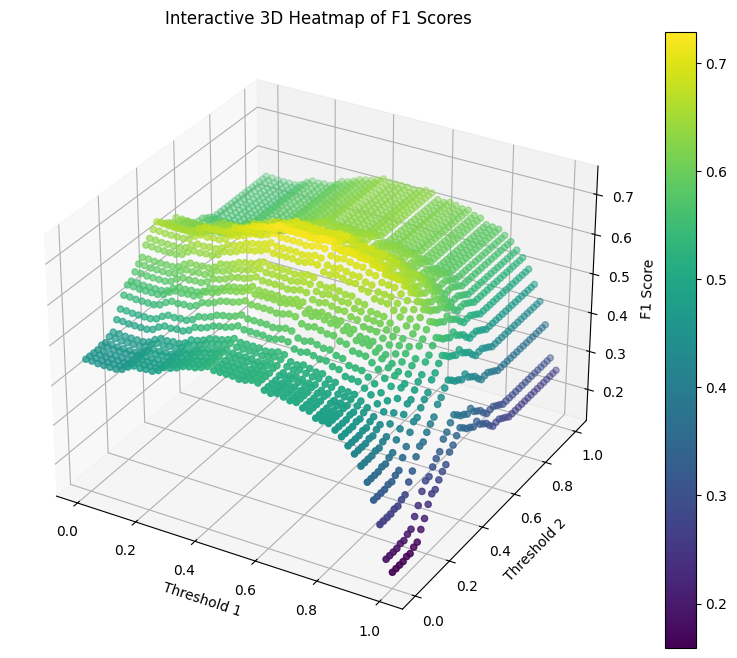

In [33]:
# Define a range of thresholds to evaluate
from itertools import product
from mpl_toolkits.mplot3d import Axes3D

thresholds = np.linspace(0, 1, 50)
threshold_combinations = list(product(thresholds, thresholds))

def classify_with_threshold(y_pred, t1, t2):
  y_pred_classes = np.zeros_like(y_pred, dtype=int)
  y_pred_classes[:, 0] = (y_pred[:, 0] > t1).astype(int)
  y_pred_classes[:, 1] = (y_pred[:, 1] > t2).astype(int)
  return y_pred_classes

# Loop over thresholds to compute F1 score for each
f1_scores = []
for t1, t2 in threshold_combinations:
    # Convert probabilities to class labels (0 or 1)
    y_pred_classes = classify_with_threshold(y_pred, t1, t2)
    # Calculate weighted F1 score
    y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.int16)
    y_pred_tensor = tf.convert_to_tensor(y_pred_classes, dtype=tf.int16)
    f1 = calculate_weighted_f1_score(y_val, y_pred_classes)
    f1_scores.append(f1)

# Convert to numpy arrays for convenience
f1_scores = np.array(f1_scores)

# Find the best threshold and corresponding F1 score
best_index = np.argmax(f1_scores)
best_threshold = threshold_combinations[best_index]
best_f1 = f1_scores[best_index]
print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)


# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert threshold combinations to x, y coordinates
x = [t[0] for t in threshold_combinations]
y = [t[1] for t in threshold_combinations]
z = f1_scores

# Create a scatter plot of F1 scores
img = ax.scatter(x, y, z, c=z, cmap='viridis')

# Highlight the best F1 score point
ax.scatter(best_threshold[0], best_threshold[1], best_f1, color='red', s=100,
           label= f'Best: {best_f1:.3f} (Threshold: {best_threshold[0]:.2f}, {best_threshold[1]:.2f})')

# Add labels and title
ax.set_xlabel('Threshold 1')
ax.set_ylabel('Threshold 2')
ax.set_zlabel('F1 Score')
ax.set_title('Interactive 3D Heatmap of F1 Scores')

# Add a color bar
fig.colorbar(img, ax=ax)

# Make the plot interactive
plt.show()



# Submission

In [42]:
# X_test_cnn = df_test_X.reshape(df_test_X.shape[0], df_test_X.shape[1], 1)
X_test_cnn = connectome_matrices_test[..., np.newaxis]
X_test_cnn.shape

(304, 200, 200, 1)

In [38]:
# y_pred = model.predict([val_feature_matrices, val_adjacency_matrices, X_val_meta])
# y_pred = model.predict(X_val_cnn)
y_pred = model.predict([X_val_cnn, X_val_meta])
# X_test_meta
y_pred[:10]

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 684ms/step


array([[0.7959651 , 0.32561   ],
       [0.6631302 , 0.21308805],
       [0.974282  , 0.35367855],
       [0.949085  , 0.13856368],
       [0.4627343 , 0.57986236],
       [0.7981347 , 0.24351336],
       [0.85186577, 0.3636844 ],
       [0.84053725, 0.23418865],
       [0.9456729 , 0.36715353],
       [0.9254804 , 0.4762097 ],
       [0.5190235 , 0.49600157],
       [0.990807  , 0.17829867],
       [0.965709  , 0.1557051 ],
       [0.9465776 , 0.26104942],
       [0.8250758 , 0.30375907],
       [0.3689472 , 0.3515932 ],
       [0.62103254, 0.30291897],
       [0.85552835, 0.15077648],
       [0.57798725, 0.34479022],
       [0.9572357 , 0.3085968 ],
       [0.94251686, 0.11747731],
       [0.97003967, 0.20382889],
       [0.9654767 , 0.21589215],
       [0.84040534, 0.32144588],
       [0.95755255, 0.20472434],
       [0.72912407, 0.44277066],
       [0.9277785 , 0.23328254],
       [0.940326  , 0.3667889 ],
       [0.96667475, 0.26313457],
       [0.98506635, 0.33633694],
       [0.

In [44]:
X_test_meta = df_test_meta_imputed
print(X_test_meta.shape)
print(X_test_cnn.shape)

test_predictions = model.predict([X_test_cnn, X_test_meta])
test_predictions_classes = classify_with_threshold(test_predictions, best_threshold[0], best_threshold[1])
print(test_predictions_classes.shape)

submission_df = pd.DataFrame(test_predictions_classes, index=test_idx, columns=df_train_y.columns)
submission_df = submission_df.reset_index(names='participant_id')
submission_df.head()

(304, 27)
(304, 200, 200, 1)
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 724ms/step
(304, 2)


,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,1,1
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0


In [ ]:
X_test_meta = df_test_meta_imputed.values
print(X_test_meta.shape)

test_predictions = model.predict([test_feature_matrices, test_adjacency_matrices, X_test_meta])
test_predictions_classes = classify_with_threshold(test_predictions, best_threshold[0], best_threshold[1])
print(test_predictions_classes.shape)

test_idx = df_test_meta_imputed.index.values
submission_df = pd.DataFrame(test_predictions_classes, index=test_idx, columns=df_train_y.columns)
submission_df = submission_df.reset_index(names='participant_id')
submission_df.head()


(304, 27)
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
(304, 2)


,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,0,0
1,vhGrzmvA3Hjq,0,0
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,0,0


In [35]:
test_predictions = model.predict(df_test_X_scaled)
# test_predictions = model.predict(X_test_cnn)
test_predictions_classes = classify_with_threshold(test_predictions, best_threshold[0], best_threshold[1])
print(test_predictions_classes.shape)

# test_idx = df_test_meta_imputed.index.values
submission_df = pd.DataFrame(test_predictions_classes, index=test_idx, columns=df_train_y.columns)
submission_df = submission_df.reset_index(names='participant_id')
submission_df.head()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(304, 2)


,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,1
1,vhGrzmvA3Hjq,0,0
2,ULliyEXjy4OV,0,1
3,LZfeAb1xMtql,1,1
4,EnFOUv0YK1RG,1,0


In [46]:
test_predictions
submission_df

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,1,1
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0
...,...,...,...
299,UadZfjdEg7eG,1,0
300,IUEHiLmQAqCi,1,0
301,cRySmCadYFRO,1,1
302,E3MvDUtJadc5,1,0


In [47]:
submission_df.to_csv('./submission/submission_pred_yiru_2D_CNN_jiaqi-imp_std_20250323.csv', index=False)